## Sagnac Frequency - Process Data

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [2]:
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta
from functions.correct_phase_jumps import __correct_phase_jumps
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.reduce import __reduce
from functions.sagnac_to_tilt import __sagnac_to_tilt
from functions.get_mlti_statistics import __get_mlti_statistics


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

case = 20
config['tbeg'] = UTCDateTime("2024-03-09 00:00")
config['tend'] = UTCDateTime("2024-04-09 00:00")
Zlower, Zupper = 553.542, 553.564
Ulower, Uupper = 302.40, 302.50
Vlower, Vupper = 447.725, 447.74

# case = 21
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# case = 22
# config['tbeg'] = UTCDateTime("2024-02-09 00:00")
# config['tend'] = UTCDateTime("2024-02-12 12:00")
# Zlower, Zupper = 553.555, 553.565
# Ulower, Uupper = 302.40, 302.45
# Vlower, Vupper = 447.745, 447.755

# case = 23
# config['tbeg'] = UTCDateTime("2024-01-01 00:00")
# config['tend'] = UTCDateTime("2024-02-20 00:00")
# Zlower, Zupper = 553.48, 553.58
# Ulower, Uupper = 302.39, 302.475
# Vlower, Vupper = 447.7, 447.80

# case = 24
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2024-01-15 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# longterm 2024
# case = 30
# config['tbeg'] = UTCDateTime("2024-01-23 00:00")
# config['tend'] = UTCDateTime("2024-06-30 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.4, 302.48
# Vlower, Vupper = 447.72, 447.78

# case = 25 # water
# config['tbeg'] = UTCDateTime("2024-05-29 00:00")
# config['tend'] = UTCDateTime("2024-06-05 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.40, 302.47
# Vlower, Vupper = 447.72, 447.78

# shortterm tilt
# case = 26
# config['tbeg'] = UTCDateTime("2024-07-06 00:00")
# config['tend'] = UTCDateTime("2024-07-17 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.4, 302.48
# Vlower, Vupper = 447.72, 447.78

config['delta'] = 60

config['n_minutes'] = 12 * config['delta']

config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

# specify path to output data
config['path_to_out_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"


In [5]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

In [6]:
def __makeplot0(beat1, beat2, beat3, key, limits=True):

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beat1.times_utc_sec*time_scaling, beat1[key])
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beat2.times_utc_sec*time_scaling, beat2[key])
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beat3.times_utc_sec*time_scaling, beat3[key])
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    if limits:
        ax[0].set_ylim(Zlower, Zupper)
        ax[1].set_ylim(Ulower, Uupper)
        ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


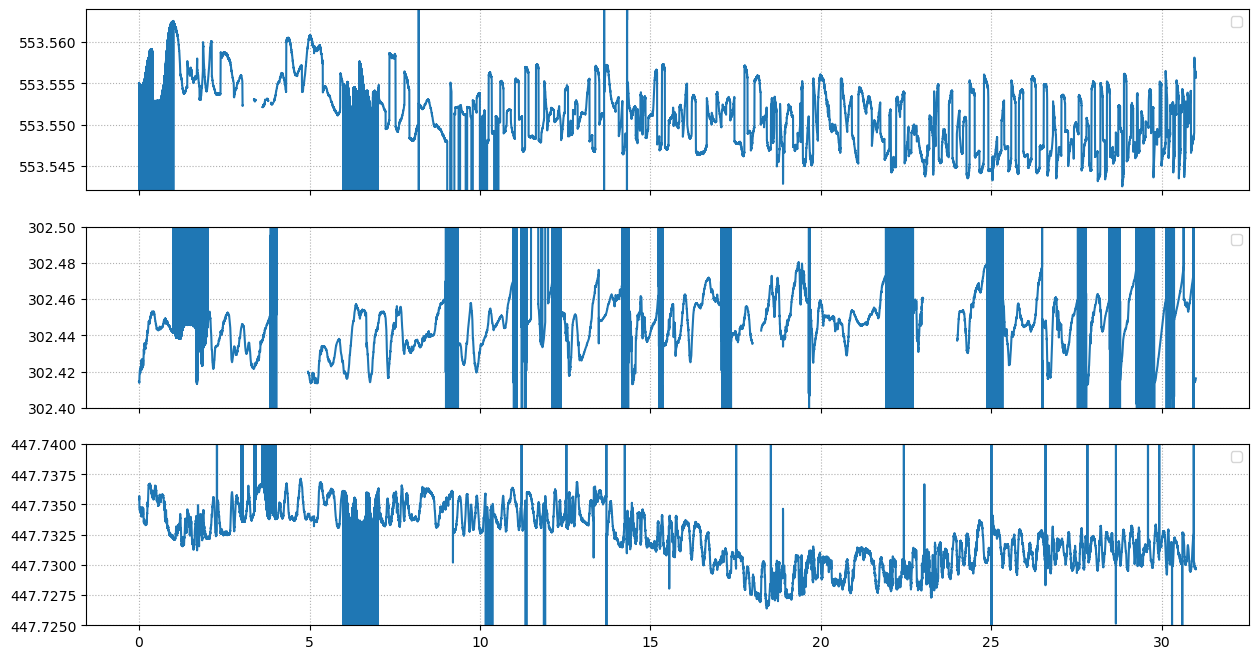

In [7]:
fig = __makeplot0(beatZ, beatU, beatV, "fj");

## Remove breakdown periods

In [8]:
timesU = [("2023-12-04T09:10", "2023-12-04T18:02"),
          ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in timesU:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])


In [9]:
timesV = [("2024-01-01T04:00", "2024-01-01T22:51"),
          ("2024-01-03T14:20", "2024-01-06T00:00"),
          ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in timesV:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])


In [10]:
timesZ = [("2023-12-07T00:10", "2023-12-08T18:05"),
          ("2024-05-30T14:00", "2024-06-02T15:00"),
          ("2024-06-03 02:00", "2024-06-23 00:00"),]

for t1, t2 in timesZ:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])


### Exclude Outliers (outside fmin and fmax)

In [11]:
beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)

beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)

beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


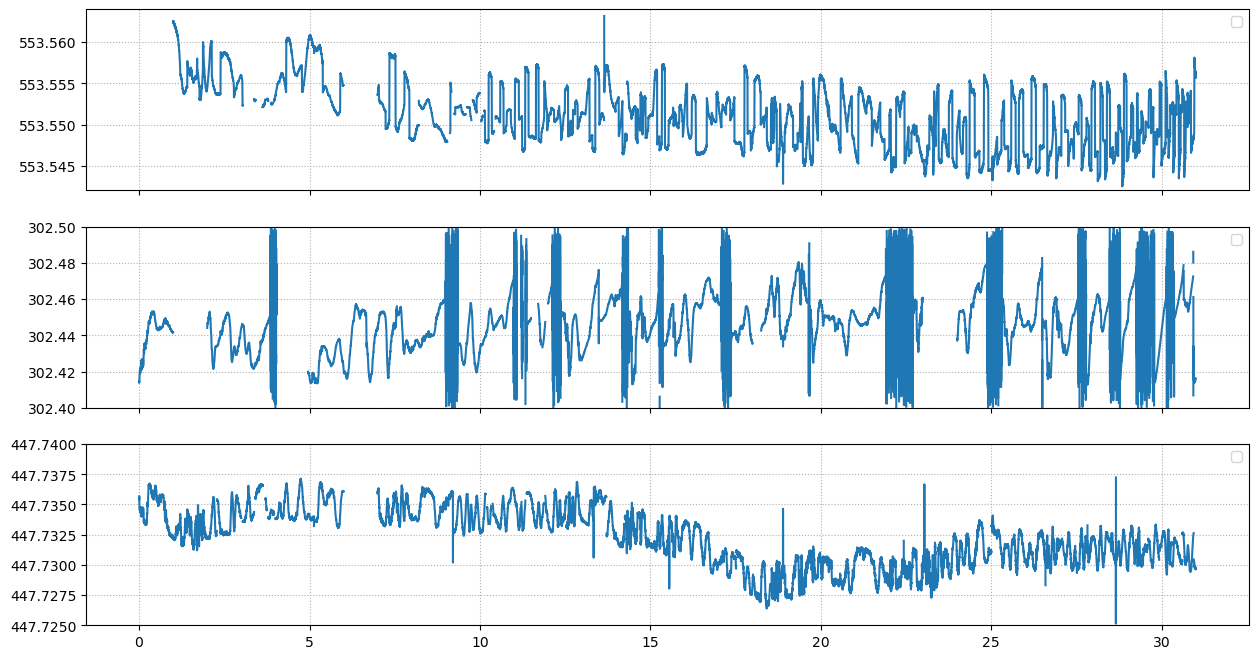

In [12]:
fig = __makeplot0(beatZ, beatU, beatV, "fj");

## Load Maintenance LXX log

In [13]:
# load LXX log data
lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

# extract time intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


## Remove MLTI times

In [14]:
# load mlti launches
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

# compute mlti sequences
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

# get index for mlti launches
mltiZ_sec = [int((UTCDateTime(_t) - config['tbeg'])/config['delta']) for _t in mltiZ.time_utc]


In [15]:
# load mlti launches
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

# compute mlti sequences
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

# get index for mlti launches
mltiU_sec = [int((UTCDateTime(_t) - config['tbeg'])/config['delta']) for _t in mltiU.time_utc]


In [16]:
# load mlti launches
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

# compute mlti sequences
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

# get index for mlti launches
mltiV_sec = [int((UTCDateTime(_t) - config['tbeg'])/config['delta']) for _t in mltiV.time_utc]


## Find jumps and correct

In [17]:
# detect phase jumps
ratio, detect = get_phase_jumps_sta_lta(np.array(beatZ.fj), np.array(beatZ.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

# add mlti launches to detected jumps for correction
for _i in mltiZ_sec:
    detect[_i] = 1

# correct phase jumps
beatZ['fj_dj'] = __correct_phase_jumps(beatZ.fj, detect)

/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))


In [18]:
# detect phase jumps
ratio, detect = get_phase_jumps_sta_lta(np.array(beatU.fj), np.array(beatU.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

# add mlti launches to detected jumps for correction
for _i in mltiU_sec:
    detect[_i] = 1

# correct phase jumps
beatU['fj_dj'] = __correct_phase_jumps(beatU.fj, detect)

/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))
/home/andbro/notebooks/SagnacFrequency/functions/correct_phase_jumps.py:11: RuntimeWarning: Mean of empty slice
  right = nanmean(data[_i+3:_i+8])
/home/andbro/notebooks/SagnacFrequency/functions/correct_phase_jumps.py:10: RuntimeWarning: Mean of empty slice
  left = nanmean(data[_i-8:_i-3])


In [19]:
# detect phase jumps
ratio, detect = get_phase_jumps_sta_lta(np.array(beatV.fj), np.array(beatV.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

# add mlti launches to detected jumps for correction
for _i in mltiV_sec:
    detect[_i] = 1

# correct phase jumps
beatV['fj_dj'] = __correct_phase_jumps(beatV.fj, detect)

/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


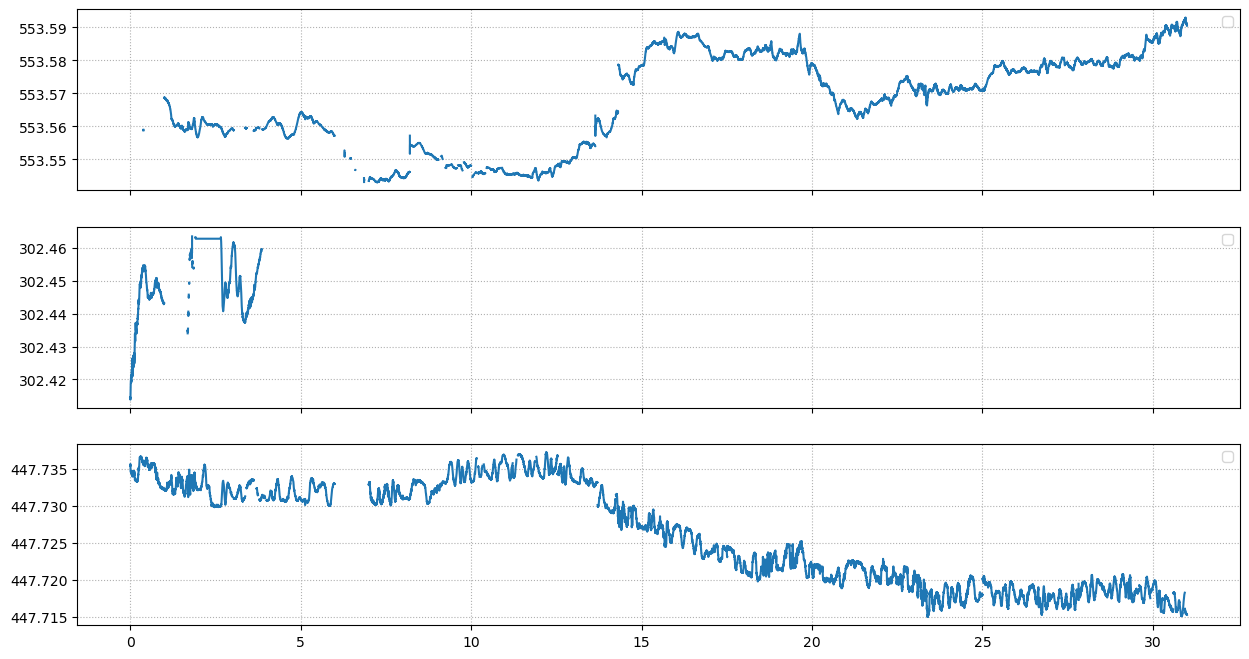

In [20]:
fig = __makeplot0(beatZ, beatU, beatV, "fj_dj", limits=False);

### Compute MLTI density

In [21]:
mltistats = {}

set_intervals = True

mltistats["U"] = __get_mlti_statistics(mltiU, config['tbeg'], config['tend'], intervals=set_intervals, plot=False, ylog=False)

mltistats["V"] = __get_mlti_statistics(mltiV, config['tbeg'], config['tend'], intervals=set_intervals, plot=False, ylog=False)

mltistats["Z"] = __get_mlti_statistics(mltiZ, config['tbeg'], config['tend'], intervals=set_intervals, plot=False, ylog=False)

In [22]:
Nsec = config['n_minutes'] * 60

mltistats["U"]["mlti_series_avg"] = __smooth(mltistats["U"]["mlti_series"], Nsec, win="hanning")
mltistats["V"]["mlti_series_avg"] = __smooth(mltistats["V"]["mlti_series"], Nsec, win="hanning")
mltistats["Z"]["mlti_series_avg"] = __smooth(mltistats["Z"]["mlti_series"], Nsec, win="hanning")

### Set MLTI intervals to NaN

In [23]:
beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [24]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [25]:

beatU['fj_smooth'] = __smooth(beatU.fj_inter, config['n_minutes'], setpad=True)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, config['n_minutes'], setpad=True)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, config['n_minutes'], setpad=True)

beatU['fj_dj_smooth'] = __smooth(beatU.fj_dj, config['n_minutes'], setpad=True)
beatV['fj_dj_smooth'] = __smooth(beatV.fj_dj, config['n_minutes'], setpad=True)
beatZ['fj_dj_smooth'] = __smooth(beatZ.fj_dj, config['n_minutes'], setpad=True)

# from scipy.ndimage import median_filter

# n_minutes = 6 * config['delta']

# beatU['fj_smooth'] = median_filter(beatU.fj_inter, n_minutes)
# beatV['fj_smooth'] = median_filter(beatV.fj_inter, n_minutes)
# beatZ['fj_smooth'] = median_filter(beatZ.fj_inter, n_minutes)

# beatU['fj_dj_smooth'] = median_filter(beatU.fj_dj, n_minutes)
# beatV['fj_dj_smooth'] = median_filter(beatV.fj_dj, n_minutes)
# beatZ['fj_dj_smooth'] = median_filter(beatZ.fj_dj, n_minutes)

# from scipy.ndimage import gaussian_filter1d

# n = 180

# beatU['fj_smooth'] = gaussian_filter1d(beatU.fj_inter, n)
# beatV['fj_smooth'] = gaussian_filter1d(beatV.fj_inter, n)
# beatZ['fj_smooth'] = gaussian_filter1d(beatZ.fj_inter, n)

# beatU['fj_dj_smooth'] = gaussian_filter1d(beatU.fj_dj, n)
# beatV['fj_dj_smooth'] = gaussian_filter1d(beatV.fj_dj, n)
# beatZ['fj_dj_smooth'] = gaussian_filter1d(beatZ.fj_dj, n)

## Masks

In [26]:
maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)
maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)
maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

In [27]:
beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU
beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV
beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

beatU['fj_dj_smooth_masked'] = beatU['fj_dj_smooth'] * maskU
beatV['fj_dj_smooth_masked'] = beatV['fj_dj_smooth'] * maskV
beatZ['fj_dj_smooth_masked'] = beatZ['fj_dj_smooth'] * maskZ

## Rotate to ZNE

In [28]:

key0 = "fj_smooth"

beatU['fj_reduced'] = __reduce(beatU[key0], 60)
beatV['fj_reduced'] = __reduce(beatV[key0], 60)
beatZ['fj_reduced'] = __reduce(beatZ[key0], 60)

beatU['fj_reduced_masked'] = beatU['fj_reduced'] * maskU
beatV['fj_reduced_masked'] = beatV['fj_reduced'] * maskV
beatZ['fj_reduced_masked'] = beatZ['fj_reduced'] * maskZ

key0 = "fj_dj_smooth"

beatU['fj_dj_reduced'] = __reduce(beatU[key0], 60)
beatV['fj_dj_reduced'] = __reduce(beatV[key0], 60)
beatZ['fj_dj_reduced'] = __reduce(beatZ[key0], 60)

beatU['fj_dj_reduced_masked'] = beatU['fj_dj_reduced'] * maskU
beatV['fj_dj_reduced_masked'] = beatV['fj_dj_reduced'] * maskV
beatZ['fj_dj_reduced_masked'] = beatZ['fj_dj_reduced'] * maskZ

## Tilt

In [29]:
key, str_key = 'fj_smooth_masked', ""
# key, str_key = 'fj_dj_smooth_masked', "dj"

# N-S
beatZ['tilt_ns'] = __sagnac_to_tilt(beatZ[key], "Z", tilt='n-s')
beatU['tilt_ns'] = __sagnac_to_tilt(beatU[key], "U", tilt='n-s')
beatV['tilt_ns'] = __sagnac_to_tilt(beatV[key], "V", tilt='n-s')

beatU['tilt_ns_reduced'] = beatU.tilt_ns - np.nanmean(beatU.tilt_ns.iloc[:2*1440])
beatV['tilt_ns_reduced'] = beatV.tilt_ns - np.nanmean(beatV.tilt_ns.iloc[:2*1440])
beatZ['tilt_ns_reduced'] = beatZ.tilt_ns - np.nanmean(beatZ.tilt_ns.iloc[:2*1440])

beatU['tilt_ns_reduced_masked'] = beatU['tilt_ns_reduced'] * maskU
beatV['tilt_ns_reduced_masked'] = beatV['tilt_ns_reduced'] * maskV
beatZ['tilt_ns_reduced_masked'] = beatZ['tilt_ns_reduced'] * maskZ

# E-W
beatZ['tilt_ew'] = __sagnac_to_tilt(beatZ[key], "Z", tilt='e-w')
beatU['tilt_ew'] = __sagnac_to_tilt(beatU[key], "U", tilt='e-w')
beatV['tilt_ew'] = __sagnac_to_tilt(beatV[key], "V", tilt='e-w')

beatU['tilt_ew_reduced'] = beatU.tilt_ew - np.nanmean(beatU.tilt_ew.iloc[:2*1440])
beatV['tilt_ew_reduced'] = beatV.tilt_ew - np.nanmean(beatV.tilt_ew.iloc[:2*1440])
beatZ['tilt_ew_reduced'] = beatZ.tilt_ew - np.nanmean(beatZ.tilt_ew.iloc[:2*1440])

beatU['tilt_ew_reduced_masked'] = beatU['tilt_ew_reduced'] * maskU
beatV['tilt_ew_reduced_masked'] = beatV['tilt_ew_reduced'] * maskV
beatZ['tilt_ew_reduced_masked'] = beatZ['tilt_ew_reduced'] * maskZ

### Store Data Frame

In [30]:
beatZ.to_pickle(f"{config['path_to_out_data']}beatz_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")
beatU.to_pickle(f"{config['path_to_out_data']}beatu_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")
beatV.to_pickle(f"{config['path_to_out_data']}beatv_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")

## Store MLTI

In [31]:
def __save_to_pickle(obj, path, name):

    import os
    import pickle

    ofile = open(path+name+".pkl", 'wb')
    pickle.dump(obj, ofile)

    if os.path.isfile(path+name+".pkl"):
        print(f"\n -> created:  {path}{name}.pkl")

In [ ]:
__save_to_pickle(mltistats, config['path_to_out_data'], f"mltistats_{config['tbeg'].date}_{config['tend'].date}")

## Store LXX

In [ ]:
lxx = DataFrame()

lxx['t1'] = lxx_t1
lxx['t2'] = lxx_t2

lxx.to_pickle(f"{config['path_to_out_data']}lxx__{config['tbeg'].date}_{config['tend'].date}.pkl")